In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from constructions import *
from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


notes:
- autoencode - regularize
- model only has holes when Xs is missing data -build_Xs_from_returns(ret, 10) leads to big holes
- add function to combine different signals (momentum, value, prev returns) 
  - shold allow for returning 2d or 1d
- add convolution layer to build common up/dn forecast
- add check for holes in Xs
- incorporate vol and cash factors

issues:
- when input data is weak, model just loads proportionally on the most likely max ticker
- optimal weights don't always beat out equal weights, but they should

In [79]:
import pandas.io.data as web
start_date = datetime.date(2005,1,1)
end_date = datetime.date(2012,5,1)
#tickers = ["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"]
tickers = ['GOOG', 'JPM', 'XOM', 'DIS', 'PFE', 'WMT']
px = web.DataReader(tickers, 'yahoo', start_date, end_date).Close
ret = px.div(px.shift()).dropna()
#ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0)

In [80]:
# risk = .2
# scaler = risk / (ret.std() * math.sqrt(250.))
# ret = ((ret - 1.) * scaler).applymap(lambda x: x + 1.)

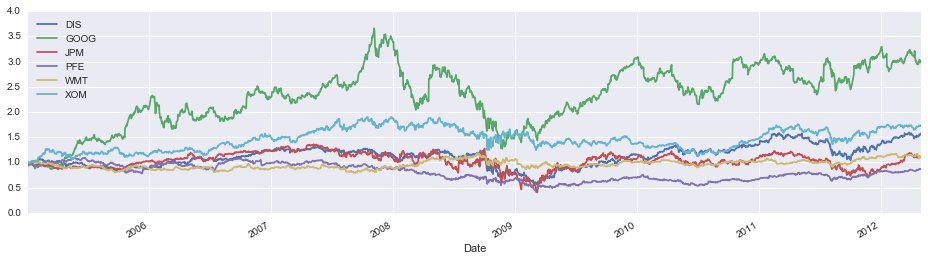

In [81]:
ret.cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [ ]:
grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

prep model inputs

In [83]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=0.000653, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 20)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [84]:
peak = get_peak_ahead_returns(ret, 20)
#hist_ret = build_Xs_from_returns(ret, 10)
cov = map_to_date(ret, '2007-1-1', get_flat_cov_matrix)
mom = xs_score(get_momentum(ret, 6*30))
val = xs_score(get_value(ret, 6*30))

In [85]:
Xs = pd.concat([peak, cov, mom, val], axis=1).dropna()

In [86]:
Xs.equals(ys)

False

In [87]:
print Xs.shape
print ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
print Xs.shape
print ys.shape
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_days=1)
Xs_train, ys_train = train[0].values, train[1].values 

(1323, 39)
(1825, 6)
(1323, 39)
(1323, 6)


In [62]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#Xs, ys = mnist.train.next_batch(1500)

n hidden layers with softmax

In [88]:
from model import *
probs, labels, stats = train_nn_softmax(Xs_train, ys_train, [5, 5], 20000, 1000, .01)

step     0:	loss: 1.79	(0.20 sec)
step   100:	loss: 1.64	(0.63 sec)
step   200:	loss: 1.56	(1.05 sec)
step   300:	loss: 1.54	(1.50 sec)
step   400:	loss: 1.53	(2.04 sec)
step   500:	loss: 1.52	(2.47 sec)
step   600:	loss: 1.53	(2.90 sec)
step   700:	loss: 1.52	(3.45 sec)
step   800:	loss: 1.51	(3.86 sec)
step   900:	loss: 1.52	(4.44 sec)
step  1000:	loss: 1.50	(4.96 sec)
step  1100:	loss: 1.51	(5.39 sec)
step  1200:	loss: 1.49	(5.82 sec)
step  1300:	loss: 1.52	(6.25 sec)
step  1400:	loss: 1.50	(6.65 sec)
step  1500:	loss: 1.51	(7.04 sec)
step  1600:	loss: 1.51	(7.47 sec)
step  1700:	loss: 1.51	(7.90 sec)
step  1800:	loss: 1.50	(8.34 sec)
step  1900:	loss: 1.51	(8.77 sec)
step  2000:	loss: 1.50	(9.21 sec)
step  2100:	loss: 1.49	(9.69 sec)
step  2200:	loss: 1.50	(10.19 sec)
step  2300:	loss: 1.50	(10.60 sec)
step  2400:	loss: 1.50	(11.05 sec)
step  2500:	loss: 1.50	(11.53 sec)
step  2600:	loss: 1.53	(12.04 sec)
step  2700:	loss: 1.51	(12.52 sec)
step  2800:	loss: 1.49	(13.08 sec)
step  2

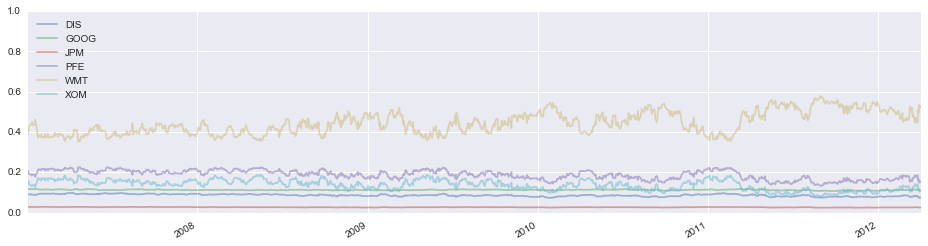

In [89]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

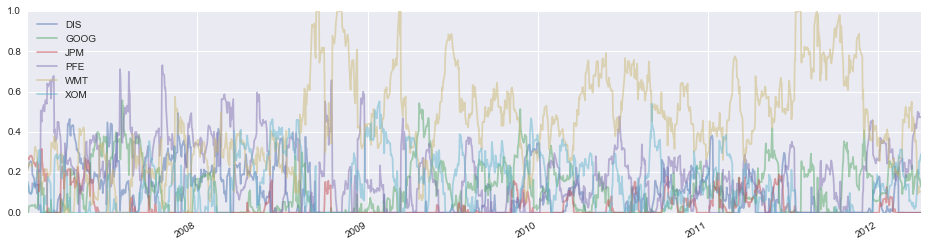

In [90]:
ys.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

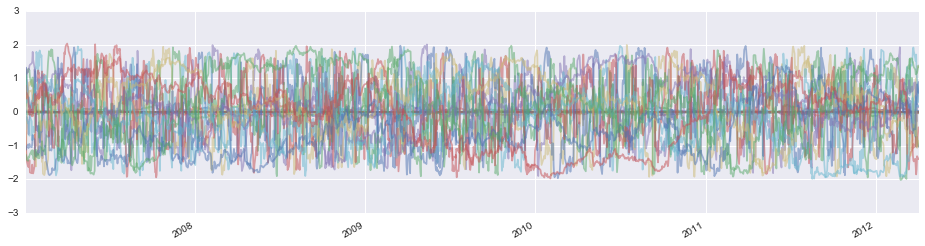

In [91]:
Xs.plot(alpha=.5, figsize=[16,4], legend=False)

In [92]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
WMT    1323
dtype: int64

actual max columns:
WMT     862
PFE     243
XOM     105
GOOG     62
DIS      42
JPM       9
dtype: int64


analytics

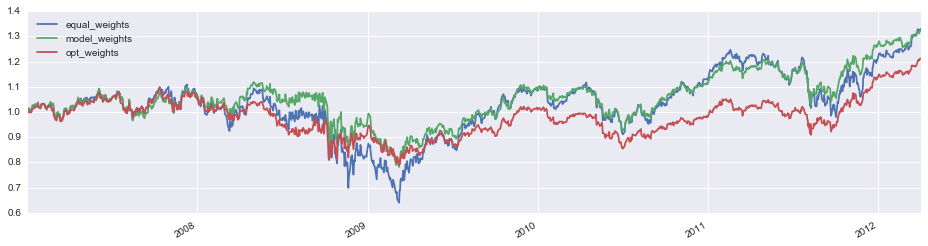

In [93]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.ix[Xs.index].cumprod().plot(figsize=[16,4])